### Import thư viện

In [284]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import cv2

In [285]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Activation

In [286]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args

### Đọc dữ liệu

In [287]:
# đọc tên các lớp :  có 9 loại
DIR = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
# DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [288]:
data = []
path = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
# path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        data.append([img, folder])

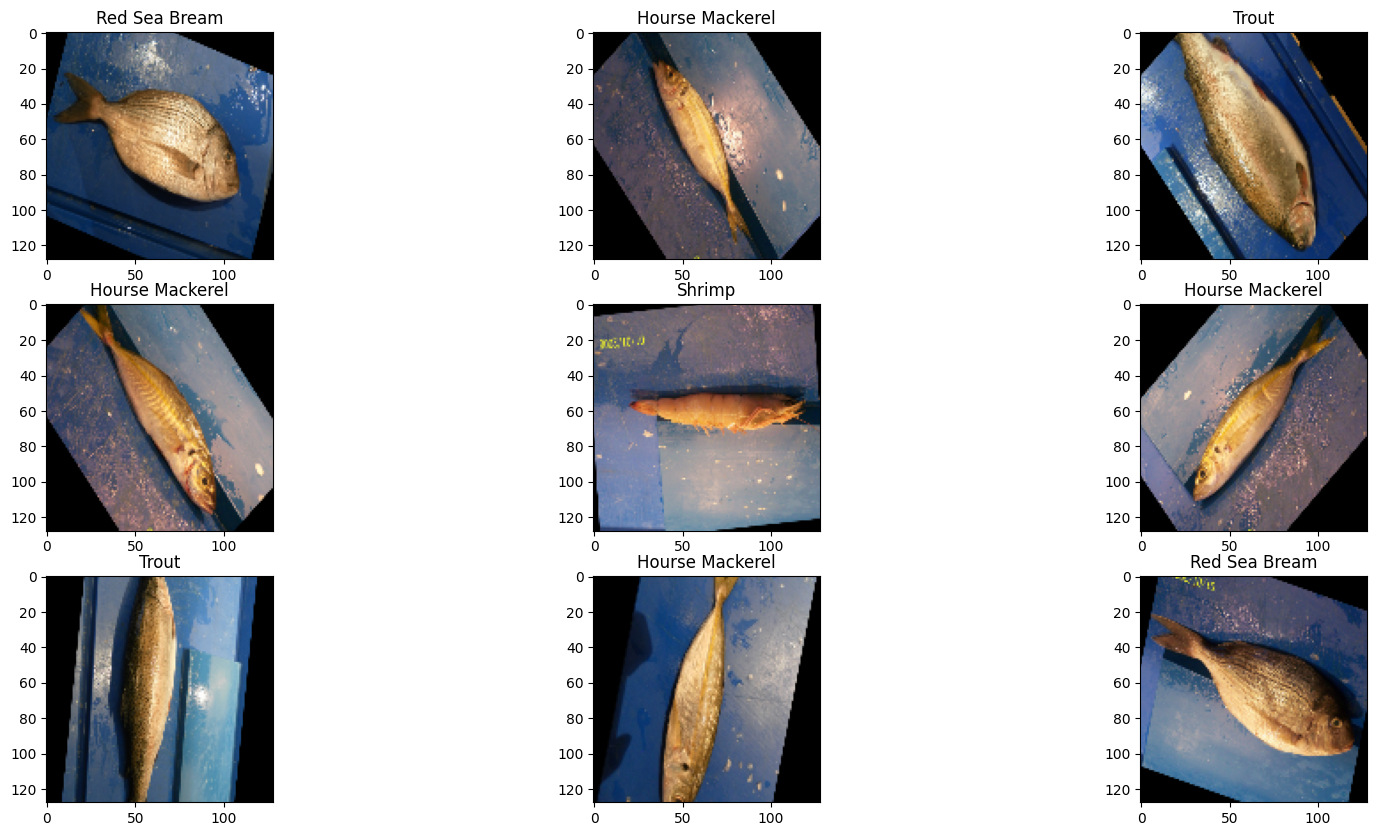

In [289]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(3,3, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [290]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [291]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [292]:
# chuẩn hóa label thành one-hot vector
# from keras.utils import np_utils
# labels = np_utils.to_categorical(labels, 9)
# labels
labels = tf.keras.utils.to_categorical(labels, num_classes=9)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [293]:
# reshape images
images = np.array(images)
# images = images.reshape(images.shape[0], 150, 150, 3)
images = images.reshape(images.shape[0], 128,128, 3)
images.shape

(9000, 128, 128, 3)

In [294]:
# chuẩn hóa images
images = images.astype('float32') / 255.0

### Chia dữ liệu Train và Validation

In [295]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((7200, 128, 128, 3), (1800, 128, 128, 3), (7200, 9), (1800, 9))

In [296]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 800, 1: 800, 2: 800, 3: 800, 4: 800, 5: 800, 6: 800, 7: 800, 8: 800}

### Xây dựng model

In [297]:
h = train_images.shape[1]
w = train_images.shape[2]
c = train_images.shape[3]

In [298]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(h,w,c)))
# # model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
# # model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
# # model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(9, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [299]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(h, w, c)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [300]:

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_59 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_52 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 59, 59, 64)      

In [301]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [ModelCheckpoint('model1.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')]
history = model.fit(train_images ,train_labels, batch_size=32, epochs=15, verbose=1, validation_data=(val_images, val_labels), callbacks= [callbacks])

Epoch 1/15
225/225 [==============================] - ETA: 0s - loss: 1.0713 - accuracy: 0.6374
Epoch 1: val_loss improved from inf to 8.55307, saving model to model1.hdf5
225/225 [==============================] - 222s 960ms/step - loss: 1.0713 - accuracy: 0.6374 - val_loss: 8.5531 - val_accuracy: 0.1111
Epoch 2/15
225/225 [==============================] - ETA: 0s - loss: 0.3925 - accuracy: 0.8744
Epoch 2: val_loss improved from 8.55307 to 4.24824, saving model to model1.hdf5
225/225 [==============================] - 221s 981ms/step - loss: 0.3925 - accuracy: 0.8744 - val_loss: 4.2482 - val_accuracy: 0.3494
Epoch 3/15
225/225 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9310
Epoch 3: val_loss improved from 4.24824 to 1.07440, saving model to model1.hdf5
225/225 [==============================] - 228s 1s/step - loss: 0.2226 - accuracy: 0.9310 - val_loss: 1.0744 - val_accuracy: 0.6761
Epoch 4/15
225/225 [==============================] - ETA: 0s - loss: 0.14

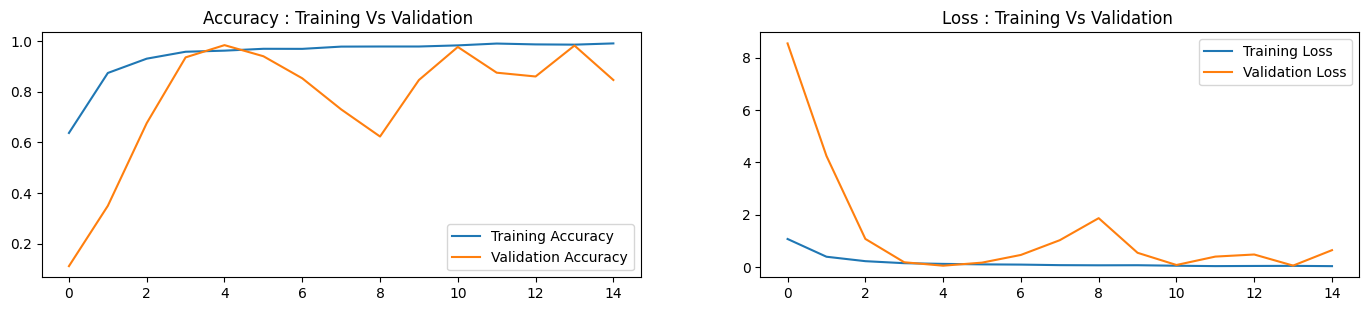

In [321]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(15), accuracy, label='Training Accuracy')
plt.plot(range(15), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training Vs Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show();

In [322]:
# Evaluating the model
model = load_model('model1.hdf5')
score = model.evaluate(val_images, val_labels, verbose=0)
print('val loss:', score[0])
print('Val accuracy:', score[1]*100,"%")

val loss: 0.049659233540296555
Val accuracy: 98.44444394111633 %


In [323]:
val_pre = model.predict(val_images)

57/57 [==============================] - 11s 190ms/step


In [324]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(val_labels.argmax(axis=1), val_pre.argmax(axis=1), target_names=classes));

                    precision    recall  f1-score   support

   Black Sea Sprat       0.96      0.99      0.98       200
   Gilt Head Bream       1.00      0.94      0.97       200
   Hourse Mackerel       0.93      1.00      0.97       200
        Red Mullet       1.00      1.00      1.00       200
     Red Sea Bream       1.00      0.99      1.00       200
          Sea Bass       0.98      0.95      0.96       200
            Shrimp       1.00      1.00      1.00       200
Striped Red Mullet       1.00      0.98      0.99       200
             Trout       1.00      1.00      1.00       200

          accuracy                           0.98      1800
         macro avg       0.99      0.98      0.98      1800
      weighted avg       0.99      0.98      0.98      1800



Xem test


In [325]:
# đọc tên các lớp :  có 9 loại
DIR_TEST = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset' 
# DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes_test = [i for i in os.listdir(DIR_TEST) if '.' not in i]                     
classes_test

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [326]:
path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset\\Gilt Head Bream\\00003.png'
img = cv2.imread(path)
height, width, channels = img.shape
print('Chiều cao:', height)
print('Chiều rộng:', width)
print('Số kênh màu:', channels)

path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset\\Black Sea Sprat\\00001.png'
img = cv2.imread(path)
height, width, channels = img.shape
print('Chiều cao:', height)
print('Chiều rộng:', width)
print('Số kênh màu:', channels)

Chiều cao: 445
Chiều rộng: 590
Số kênh màu: 3
Chiều cao: 445
Chiều rộng: 590
Số kênh màu: 3


In [327]:
data_test = []
# path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset"
path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset'
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        data_test.append([img, folder])


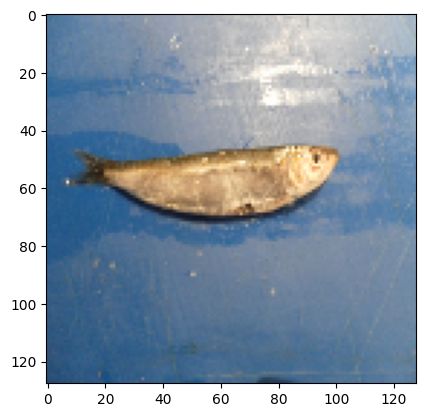

(128, 128, 3)


In [328]:
im = data_test[0][0]
plt.imshow(im)
plt.show()
print(im.shape)

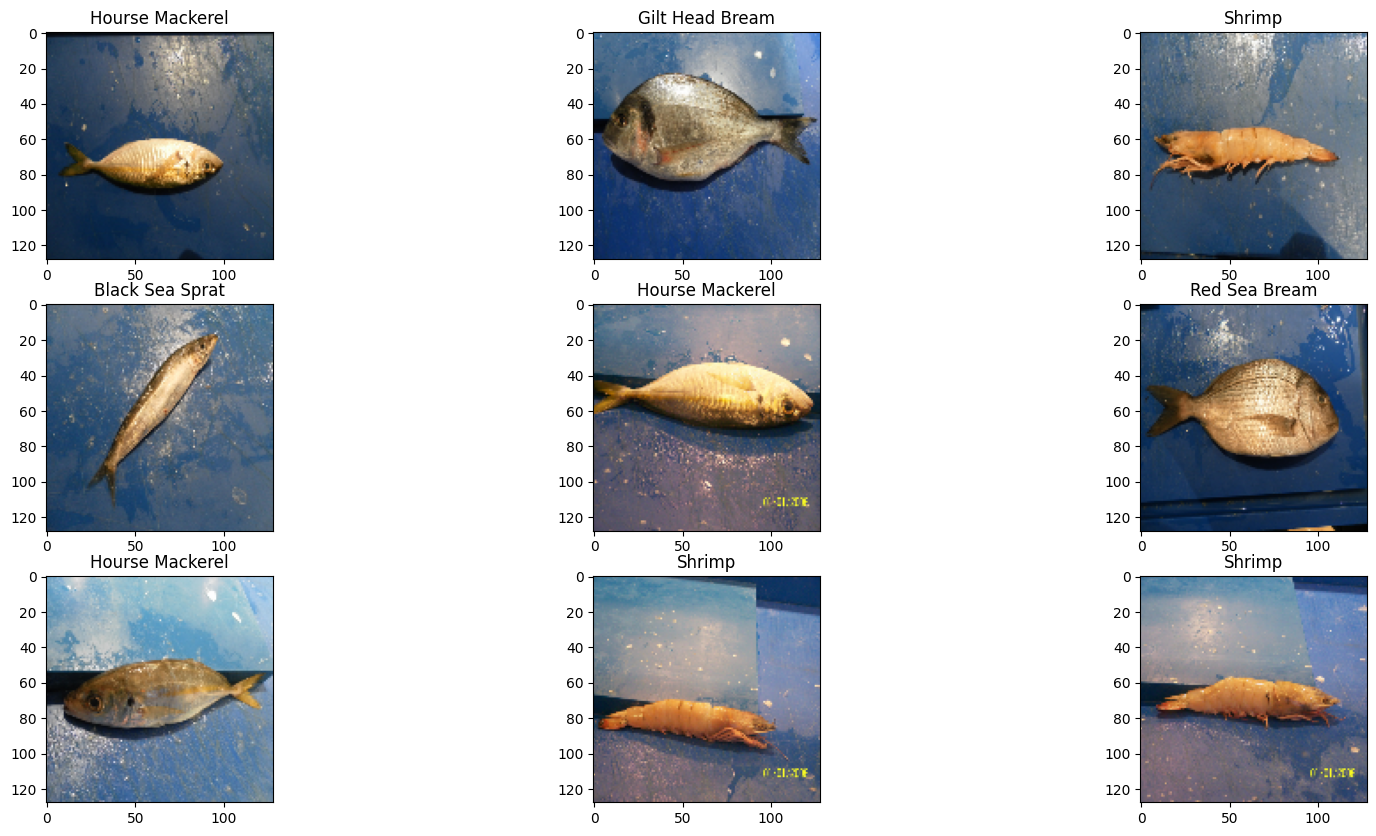

In [329]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(3,3, i+1)
    j = np.random.randint(0, 429)
    plt.imshow(data_test[j+i][0])
    plt.title(data_test[j+i][1])

In [330]:
# shuffle data_test
import random
random.shuffle(data_test)

In [331]:
# tạo image và label từ data_test
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [332]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [333]:
# chuẩn hóa label thành one-hot vector
# from keras.utils import np_utils
# test_labels = np_utils.to_categorical(test_labels, 9)
# test_labels

test_labels  = tf.keras.utils.to_categorical(test_labels , num_classes=9)
test_labels 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [334]:
# reshape images
test_images = np.array(test_images)
# images = images.reshape(images.shape[0], 150, 150, 3)
test_images = test_images.reshape(test_images.shape[0], 128,128, 3)
test_images.shape

(430, 128, 128, 3)

In [335]:
test_images.shape, test_labels.shape

((430, 128, 128, 3), (430, 9))

In [336]:
# chuẩn hóa images
test_images = test_images.astype('float32') / 255.0

In [337]:
test_pre = model.predict(test_images)

14/14 [==============================] - 3s 195ms/step


In [338]:
# Evaluating the model
model = load_model('model1.hdf5')
score = model.evaluate(test_images,test_labels,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100,"%")

Test loss: 0.28117498755455017
Test accuracy: 91.86046719551086 %


In [339]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels.argmax(axis=1), test_pre.argmax(axis=1), target_names=classes_test));

                    precision    recall  f1-score   support

   Black Sea Sprat       0.78      1.00      0.88        50
   Gilt Head Bream       0.84      0.96      0.90        50
   Hourse Mackerel       0.97      0.70      0.81        50
        Red Mullet       1.00      1.00      1.00        50
     Red Sea Bream       0.90      0.92      0.91        50
          Sea Bass       0.90      0.94      0.92        50
            Shrimp       1.00      1.00      1.00        50
Striped Red Mullet       0.98      1.00      0.99        50
             Trout       1.00      0.63      0.78        30

          accuracy                           0.92       430
         macro avg       0.93      0.91      0.91       430
      weighted avg       0.93      0.92      0.92       430

